## Example notebook which shows how to make class oversampling/undersampling in TF+datasets API

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import pandas

%matplotlib inline

/home/mkk/anaconda3/envs/pmi36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
keras.__version__, tf.__version__

('2.0.8', '1.4.0')

## Prepare fake dataset with class imbalance

In [3]:
# Hardcoded class probabilities
class_probs = dict(
    a=0.15,
    b=0.3,
    c=0.8,
    d=0.9,
    e=0.2,
    f=0.02
)
num_classes = len(class_probs)


# Normalize probabilities
class_probs = {k:v/sum(class_probs.values()) for k,v in class_probs.items()} 
class_mapping = {n: i for i, n in enumerate(class_probs.keys())}


# Sample dataset from 'class_probs'
class_names = list(class_probs.keys())
class_weights = list(class_probs.values())
sampled_dataset = np.random.choice(class_names, size=1000, p=class_weights)


# Prepare dataset
dataset_data = defaultdict(list)
for i, d in enumerate(sampled_dataset):
    dataset_data['class_name'].append(d)
    dataset_data['class_id'].append(class_mapping[d])    
    dataset_data['data'].append(np.array([i])) # some data here, e.g. image pixels
    dataset_data['class_prob'].append(class_probs[d]) # a real class probability 
    # desired probability - a ideal class uniform
    dataset_data['class_target_prob'].append(1/num_classes) 

    
# Convert values to in dataset_data to vectors of shape (1000, )
for k, v in dataset_data.items():
    dataset_data[k] = np.array(dataset_data[k])

## Plot initial class probabilities

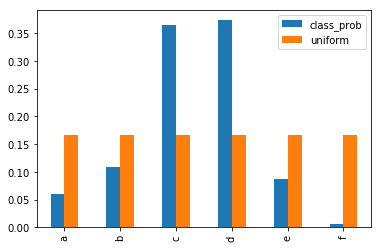

In [4]:
class_counts = Counter(sampled_dataset)
df = pandas.DataFrame()
df['class_prob'] = pandas.DataFrame.from_dict(class_counts, orient='index')[0]
df['uniform'] = 1
df = df/df.sum(0)
df.sort_index().plot(kind='bar')

### An ideal uniform class probability

In [5]:
1/num_classes

0.16666666666666666

### The actual class probabilities

In [6]:
class_probs

{'a': 0.06329113924050632,
 'b': 0.12658227848101264,
 'c': 0.33755274261603374,
 'd': 0.37974683544303794,
 'e': 0.08438818565400844,
 'f': 0.008438818565400843}

## Prepare sampling pipeline

In [7]:
# sampling parameters use it wisely 
oversampling_coef = 0.9 # if equal to 0 then oversample_classes() always returns 1
undersampling_coef = 0.9 # if equal to 0 then undersampling_filter() always returns True

In [8]:
def oversample_classes(example):
    """
    Returns the number of copies of given example
    """
    class_prob = example['class_prob']
    class_target_prob = example['class_target_prob']
    prob_ratio = tf.cast(class_target_prob/class_prob, dtype=tf.float32)
    # soften ratio is oversampling_coef==0 we recover original distribution
    prob_ratio = prob_ratio ** oversampling_coef 
    # for classes with probability higher than class_target_prob we
    # want to return 1
    prob_ratio = tf.maximum(prob_ratio, 1) 
    # for low probability classes this number will be very large
    repeat_count = tf.floor(prob_ratio)
    # prob_ratio can be e.g 1.9 which means that there is still 90%
    # of change that we should return 2 instead of 1
    repeat_residual = prob_ratio - repeat_count # a number between 0-1
    residual_acceptance = tf.less_equal(
                        tf.random_uniform([], dtype=tf.float32), repeat_residual
    )

    residual_acceptance = tf.cast(residual_acceptance, tf.int64)
    repeat_count = tf.cast(repeat_count, dtype=tf.int64)

    return repeat_count + residual_acceptance


def undersampling_filter(example):
    """
    Computes if given example is rejected or not.
    """
    class_prob = example['class_prob']
    class_target_prob = example['class_target_prob']
    prob_ratio = tf.cast(class_target_prob/class_prob, dtype=tf.float32)
    prob_ratio = prob_ratio ** undersampling_coef
    prob_ratio = tf.minimum(prob_ratio, 1.0)

    acceptance = tf.less_equal(tf.random_uniform([], dtype=tf.float32), prob_ratio)
    # predicate must return a scalar boolean tensor
    return acceptance

dataset = tf.contrib.data.Dataset.from_tensor_slices(dict(dataset_data))
dataset = dataset.flat_map(
    lambda x: tf.data.Dataset.from_tensors(x).repeat(oversample_classes(x))
)

dataset = dataset.filter(undersampling_filter)

dataset = dataset.repeat(-1)
dataset = dataset.shuffle(2048)
dataset = dataset.batch(32)

sess = K.get_session()
sess.run(tf.global_variables_initializer())

iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

Instructions for updating:
Use `tf.data.Dataset.from_tensor_slices()`.


## Iterate over dataset and generate class histograms

In [9]:
from tqdm import tqdm
from collections import defaultdict
class_count = defaultdict(int)

for i in tqdm(range(1000)):
    data = sess.run(next_element)
    for d in data['class_name']:              
        class_count[d] += 1

100%|██████████| 1000/1000 [00:05<00:00, 192.06it/s]


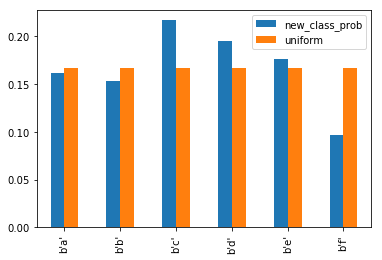

In [10]:
df = pandas.DataFrame.from_dict(class_count, orient='index')
df['uniform'] = 1
df = df/df.sum(0)
df.columns = ['new_class_prob', 'uniform']
df.sort_index().plot(kind='bar')